In [21]:
from vedo import dataurl, Mesh, Plotter, Volume, settings, LinearTransform, Box, Line
import numpy as np
import pandas as pd
from normalize import normalize_shape,get_eigenvectors,get_center_of_mass
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

"""
Input Mesh
Output one of Mixed,Quad,Triangle,Other (in case of non quad or triangle polygons)
"""

cellType = {
        3:"Triangle",
        4:"Quad"
    }
freq = {
        "Other":0,
        "Quad":0,
        "Triangle":0,
    }

def GetCellType(cells):
    for i in range(0,len(cells)):
        l = len(cells[i])
        #print(l,cellType[l])
        if(l in cellType):
            option = cellType[l]
        else:
            option = "Other"
        #print(option)
        val = freq.get(option)
        freq.update({option:val+1})

    if(freq["Other"])>0:
        return "Other"
    elif(freq["Quad"])==0:
        return "Triangle"
    elif(freq["Triangle"])==0:
        return "Quad"
    else:
        return "Mixed"
    
def get_vertex_dist(mesh:Mesh):
    #As the ratio of the smallest cell against largest cell
    minar = np.inf
    maxar = 0
    for idx in range(0,len(mesh.vertices)):
        ar = 0
        for cp in mesh.connected_vertices(idx):
            ar+= np.abs(np.linalg.norm(mesh.vertices[idx] - mesh.vertices[cp]))
        

        if ar!=0 and ar<minar:
            minar=ar
        elif ar!=0 and ar>maxar:
            maxar=ar
        #print(ar,minar,maxar)

    return maxar/minar

def calculate_flipping_momentum(mesh: Mesh):
    """
    Compute flipping momentum components f_x, f_y, f_z.
    If positive, the majority of the mass is in the positive half of the respective axis.
    """
    
    f = [0.0, 0.0, 0.0]
    for i1, i2, i3 in mesh.cells:
        v1, v2, v3 = mesh.vertices[i1], mesh.vertices[i2], mesh.vertices[i3]
        Ct = (v1 + v2 + v3) / 3.0  # center of triangle
        for i in range(3):  # loop over x, y, z
            f[i] += np.sign(Ct[i]) * (Ct[i] ** 2)
    return f  # f_x, f_y, f_z
def euclidean_distances(list1, list2=None):
    distances = []
    if(list2 is None):
        matrix = np.array([list(map(float, x.replace('[', '').replace(']', '').split())) for x in list1])
        distances = np.linalg.norm(matrix,axis=1)
    else:
        for point1, point2 in zip(list1, list2):
            # Convert points to NumPy arrays for easier calculations
            p1 = np.array(point1)
            p2 = np.array(point2)
            # Calculate Euclidean distance
            distance = np.linalg.norm(p1 - p2)
            distances.append(distance)
    
    return distances

Step 2.1: Analyzing a single shape

Start building a simple tool that checks all shapes in the database. The tool should output, for each shape

    the class of the shape
    the number of faces and vertices of the shape
    the type of faces (e.g. only triangles, only quads, mixes of triangles and quads)
    the axis-aligned 3D bounding box of the shapes 

In [2]:
"""
Input: (Optional) Path of database, limit
Output: Pandas Dataframe with metainformation about each object, size limit. If no limit is set, the entire database is read

The following properties are computed
    the class of the shape
    the number of faces 
    number of vertices of the shape
    the type of faces (e.g. only triangles, only quads, mixes of triangles and quads)
    the axis-aligned 3D bounding box of the shapes 
    Additionally, average size, diagonal size, position, center of mass and scaling are retrieved
"""
df_manifest = pd.read_csv("./subset_shape_manifest.csv")  # Subset


def RetrieveShapeMeta(
    df_manifest=df_manifest[df_manifest['ReturnCode'] == 0], limit=None, filename="metadata.csv"
):
    paths = []
    vertices = []
    com = []
    means = []
    scalings = []
    s_average = []
    s_diagonal = []
    bounds = []
    positions = []
    cls = []
    cells = []
    types = []
    eigenvals = []
    eigenvecs = []
    vecdist = []
    flipping_momentum = []
    i = 0
    t = tqdm(map(Path, df_manifest['Path']), total=limit if limit else len(df_manifest))
    for path in map(Path, t):
        t.set_description(desc=f"Reading {path} -- exists {path.exists()}")
        if not path.exists():
            continue
        if limit != None and i > limit:
            break
        # className = subdir.split("\\")[-1]
        # path = os.path.join(subdir, file)
        className = path.parent.name
        paths.append(str(path))
        mesh = Mesh(str(path))
        vertices.append(len(mesh.vertices))
        com.append(mesh.center_of_mass())
        means.append(np.mean(mesh.vertices, axis=0))
        scalings.append(mesh.scale())
        s_average.append(mesh.average_size())
        s_diagonal.append(mesh.diagonal_size())
        positions.append(mesh.pos())
        bounds.append(mesh.bounds())
        cells.append(mesh.ncells)
        vecdist.append(get_vertex_dist(mesh))
        cls.append(className)
        faceType = GetCellType(mesh.cells)
        types.append(faceType)
        eigenval, eigenvec = get_eigenvectors(mesh)
        eigenvals.append(eigenval)
        eigenvecs.append(eigenvec)
        f_x, f_y, f_z = calculate_flipping_momentum(mesh)
        flipping_momentum.append([f_x, f_y, f_z])
        
        i += 1

    df = pd.DataFrame(
        {
            "Path": paths,
            "Vertices": vertices,
            "CenterOfMass": com,
            "Means": means,
            "Scaling": scalings,
            "AverageSize": s_average,
            "DiagonalSize": s_diagonal,
            "Bounds": bounds,
            "Position": positions,
            "Cells": cells,
            "Class": cls,
            "Type": types,
            "Eigenvalue": eigenvals,
            "Eigenvectors": eigenvecs,
            "Distribution": vecdist,
            "FlippingMomentum": flipping_momentum
        }
    )
    df.to_csv(filename)
    return df


df = RetrieveShapeMeta(limit=None, filename="metadata_subset.csv")
# df = pd.read_csv("metadata.csv")
print(df)

Reading ../shapes/AircraftBuoyant/m1337.obj -- exists True:   0%|          | 0/396 [00:00<?, ?it/s]

Reading ../shapes/WheelChair/D00846.obj -- exists True: 100%|██████████| 396/396 [04:48<00:00,  1.37it/s]         


                                    Path  Vertices  \
0    ../shapes/AircraftBuoyant/m1337.obj       201   
1    ../shapes/AircraftBuoyant/m1341.obj       425   
2    ../shapes/AircraftBuoyant/m1342.obj      1252   
3    ../shapes/AircraftBuoyant/m1344.obj      1093   
4    ../shapes/AircraftBuoyant/m1345.obj      3174   
..                                   ...       ...   
391      ../shapes/WheelChair/D00453.obj       709   
392      ../shapes/WheelChair/D00604.obj       986   
393      ../shapes/WheelChair/D00628.obj     29552   
394      ../shapes/WheelChair/D00821.obj      8188   
395      ../shapes/WheelChair/D00846.obj      8834   

                                          CenterOfMass  \
0    [0.4580643383084576, 0.515897412935323, 0.4566...   
1    [0.20235556470588228, 0.3940621458823527, 0.20...   
2    [0.3500421988817893, 0.23383409584664513, 0.30...   
3    [0.3500595544373309, 0.2901313119853607, 0.349...   
4    [0.313048325141777, 0.5899973657844969, 0.3130...   
.. 

Step 2.2: Statistics over the whole database

Use the output of the tool, e.g. saved in an Excel sheeet or CSV file, to find out 
(a) what is the average shape in the database (in terms of vertex and face counts); and 
(b) if there are significant outliers from this average (e.g. shapes having many, or few, vertices or cells). The best way to do this is to show a histogram counting how many shapes are in the database for every range of the property of interest (e.g., number of vertices, number of faces, shape class).

Use the viewer constructed in step 1 to show an average shape and a few such outliers (if any). 

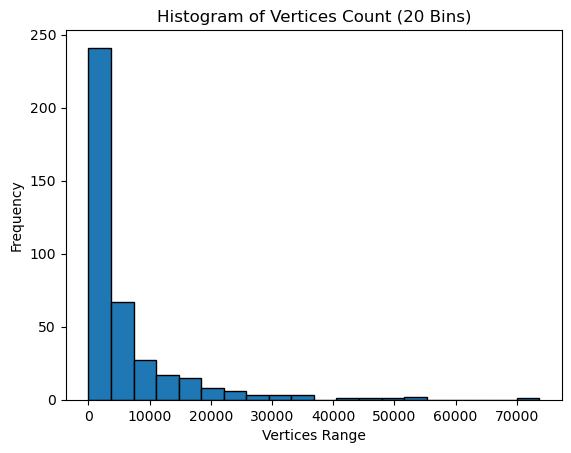

Mean Vertex Count: 5633.121212121212
Standard Deviation Vertex Count: 9028.327094020284
Max Vertex Count: 73697-../shapes/Skyscraper/D00058.obj
Min Vertex Count: 18-../shapes/Door/D01194.obj


In [3]:
#VERTICES STATISTICS

plt.hist(df['Vertices'], bins=20, edgecolor='black')

# Adding labels and title
plt.xlabel('Vertices Range')
plt.ylabel('Frequency')
plt.title('Histogram of Vertices Count (20 Bins)')

# Display the histogram
plt.show()

#Get Outliers
maxind = np.argmax(df['Vertices'])
minind = np.argmin(df['Vertices'])

print(f"Mean Vertex Count: {np.mean(df['Vertices'])}")
print(f"Standard Deviation Vertex Count: {np.std(df['Vertices'])}")
print(f"Max Vertex Count: {np.max(df['Vertices'])}-{df.loc[maxind]['Path']}")
print(f"Min Vertex Count: {np.min(df['Vertices'])}-{df.loc[minind]['Path']}")

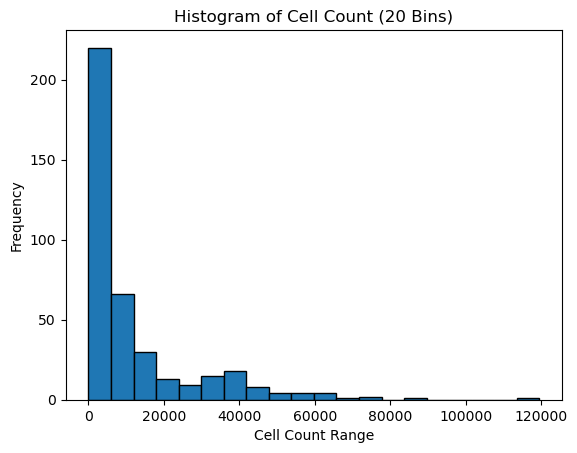

Mean Cell Count: 11530.126262626263
Standard Deviation Cell Count: 16419.705266219375
Max Cell Count: 119540-../shapes/Car/m1556.obj
Min Cell Count: 18-../shapes/Door/D01194.obj


In [4]:
#EDGE STATISTICS

plt.hist(df['Cells'], bins=20, edgecolor='black')

# Adding labels and title
plt.xlabel('Cell Count Range')
plt.ylabel('Frequency')
plt.title('Histogram of Cell Count (20 Bins)')

# Display the histogram
plt.show()

#Get Outliers
maxind = np.argmax(df['Cells'])
minind = np.argmin(df['Cells'])

print(f"Mean Cell Count: {np.mean(df['Cells'])}")
print(f"Standard Deviation Cell Count: {np.std(df['Cells'])}")
print(f"Max Cell Count: {np.max(df['Cells'])}-{df.loc[maxind]['Path']}")
print(f"Min Cell Count: {np.min(df['Cells'])}-{df.loc[minind]['Path']}")


In [5]:
def euclidean_distances(list1, list2=None):
    distances = []
    if(list2 is None):
        matrix = np.array([list(map(float, x.replace('[', '').replace(']', '').split())) for x in list1])
        distances = np.linalg.norm(matrix,axis=1)
    else:
        for point1, point2 in zip(list1, list2):
            # Convert points to NumPy arrays for easier calculations
            p1 = np.array(point1)
            p2 = np.array(point2)
            # Calculate Euclidean distance
            distance = np.linalg.norm(p1 - p2)
            distances.append(distance)
    
    return distances


In [6]:
distances = euclidean_distances(df["CenterOfMass"], df["Position"])

ind = np.argmax(distances)
print(ind,df.loc[ind])

249 Path                              ../shapes/PianoBoard/D00755.obj
Vertices                                                     8133
CenterOfMass    [59.51381916881735, -164.23005681790076, 79.33...
Means           [59.51381916881735, -164.23005681790076, 79.33...
Scaling                                           [1.0, 1.0, 1.0]
AverageSize                                             51.741669
DiagonalSize                                           279.745372
Bounds          [33.6835, 131.834, -272.329, -55.6096, 1.94, 1...
Position                                          [0.0, 0.0, 0.0]
Cells                                                       49260
Class                                                  PianoBoard
Type                                                     Triangle
Eigenvalue      [[-0.9980894956940142, -0.06178272579088406, 0...
Eigenvectors    [163.8513941968489, 924.1353565925001, 2447.27...
Distribution                                          9315.901377
Name: 

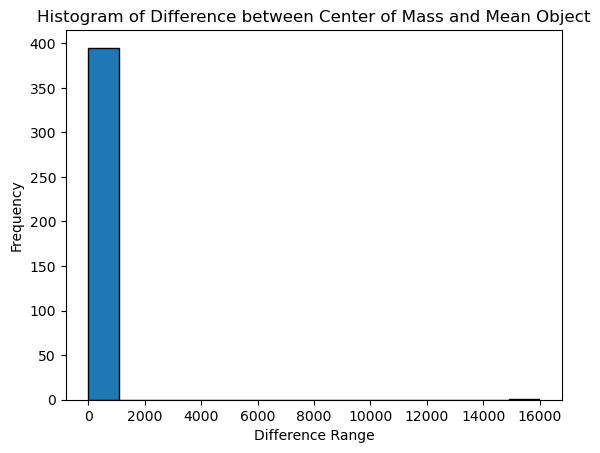

In [12]:
plt.hist(distances, bins=15, edgecolor='black')

# Adding labels and title
plt.xlabel('Difference Range')
plt.ylabel('Frequency')
plt.title('Histogram of Difference between Center of Mass and Mean Object')

# Display the histogram
plt.show()

In [8]:
df["Type"].unique()

array(['Triangle'], dtype=object)

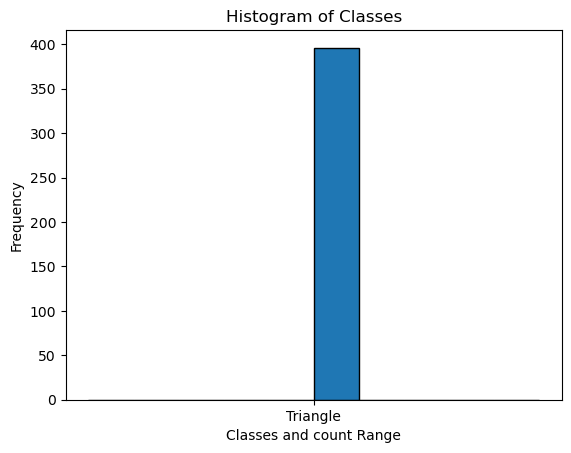

In [9]:
#Investigating Classes
plt.hist(df['Type'], edgecolor='black')

# Adding labels and title
plt.xlabel('Classes and count Range')
plt.ylabel('Frequency')
plt.title('Histogram of Classes')

# Display the histogram
plt.show()


In [10]:
settings.default_backend = 'k3d'
filepath = "..\shapes\AircraftBuoyant\m1338.obj"
filepath2 = "..\shapes\AircraftBuoyant\m1338.obj"

mesh = Mesh(filepath).c("violet").flat()
mesh2 = Mesh(filepath2).c("green").flat()

# Set the backcolor of the mesh to violet
# and show edges with a linewidth of 2
mesh.backcolor('violet').linecolor('tomato').linewidth(2)
mesh.transform.set_position(mesh.pos()+[5,5,5])
print(mesh)

mesh2.transform.set_position(mesh2.pos()-mesh2.center_of_mass())
print(mesh2)
plot = Plotter(bg='black')
plot.show(mesh,mesh2)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_6741/3540993788.py:2: SyntaxWarning: invalid escape sequence '\s'
  filepath = "..\shapes\AircraftBuoyant\m1338.obj"
/tmp/ipykernel_6741/3540993788.py:3: SyntaxWarning: invalid escape sequence '\s'
  filepath2 = "..\shapes\AircraftBuoyant\m1338.obj"
[vedo.file_io] ERROR: in load(), cannot load ..\shapes\AircraftBuoyant\m1338.obj
/tmp/ipykernel_6741/3540993788.py:2: SyntaxWarning: invalid escape sequence '\s'
  filepath = "..\shapes\AircraftBuoyant\m1338.obj"
/tmp/ipykernel_6741/3540993788.py:3: SyntaxWarning: invalid escape sequence '\s'
  filepath2 = "..\shapes\AircraftBuoyant\m1338.obj"


AttributeError: 'NoneType' object has no attribute 'dataset'

NORMALISATION STEPS

position: d(ci>0)~0
pose: eigenvectors * axis = 1 (for x,y,z axis)
remeshing: Check that target value for vertices is met. Histogram ||Vi|-T|| ~ 0 (satisfied in most condition)  
flip vector = ([1,0,0][0,1,0],[0,0,1])
size - largest bounding box axis = 1 

GLOBAL DESCRIPTORS
HISTOGRAMS
Comparing Histograms (for comparing different features) - Histogram of feature becomes a point
Area normalisation (Euclidian distance) - 
Angle normalisation for Histograms.  Distance = cosine similarity

cumulative histogram (more robust with respect to outliers) (con: unintuitive, technical instrument to remove noise)
Limitations of histograms for 3D descriptors: 

CALCULATING EDGES
First derivative large (i.e rapid change from dark to light)
Laplacian is close to 0 -> Sum of second derivatives (with respect to x, y ,z ) is close to 0 -> Point where accelleration turns into 0, Curvature concave turns into convex.





In [11]:
def NormalizeShapes(
    df_manifest=df_manifest[df_manifest['ReturnCode'] == 0], targetdir="../normshapes", limit=None, filename="metadata.csv"
):
    orig_paths = []
    vertices = []
    com = []
    means = []
    scalings = []
    s_average = []
    s_diagonal = []
    bounds = []
    positions = []
    cls = []
    cells = []
    types = []
    new_paths = []
    eigenvals = []
    eigenvecs = []
    peigenvals = []
    peigenvecs = []
    flipping_momentum_before = []
    flipping_momentum_after = []
    i = 0
    t = tqdm(map(Path, df_manifest["Path"]), total=limit if limit else len(df_manifest))
    for path in map(Path, t):
        t.set_description(desc=f"Reading {path}")
        if not path.exists():
            continue
        if limit != None and i > limit:
            break
        className = path.parent.name
        npath = Path(targetdir) / className / path.name
        npath.parent.mkdir(parents=True, exist_ok=True)
        # path = os.path.join(subdir, file)
        # subpath = os.path.join(targetdir, className)
        # Path(subpath).mkdir(parents=True, exist_ok=True)
        # npath = os.path.join(targetdir, className, file)
        orig_paths.append(str(path))
        new_paths.append(str(npath))
        mesh = Mesh(str(path))
        peigenvec, peigenval = get_eigenvectors(mesh)
        f_x_before, f_y_before, f_z_before = calculate_flipping_momentum(mesh)
        flipping_momentum_before.append([f_x_before, f_y_before, f_z_before])
        
        mesh = normalize_shape(mesh)
     
        f_x_after, f_y_after, f_z_after = calculate_flipping_momentum(mesh)
        flipping_momentum_after.append([f_x_after, f_y_after, f_z_after])
        eigenvec, eigenval = get_eigenvectors(mesh)
        vertices.append(len(mesh.vertices))
        com.append(mesh.center_of_mass())
        means.append(get_center_of_mass(mesh))
        scalings.append(mesh.scale())
        s_average.append(mesh.average_size())
        s_diagonal.append(mesh.diagonal_size())
        positions.append(mesh.pos())
        bounds.append(mesh.bounds())
        cells.append(mesh.ncells)
        cls.append(className)
        faceType = GetCellType(mesh.cells)
        types.append(faceType)
        peigenvals.append(peigenval)
        peigenvecs.append(peigenvec)
        eigenvals.append(eigenval)
        eigenvecs.append(eigenvec)

        mesh.write(str(npath))
        i += 1

    df = pd.DataFrame(
        {
            "New Path": new_paths,
            "Orig Path": orig_paths,
            "Vertices": vertices,
            "CenterOfMass": com,
            "Means": means,
            "Scaling": scalings,
            "AverageSize": s_average,
            "DiagonalSize": s_diagonal,
            "Bounds": bounds,
            "Position": positions,
            "Cells": cells,
            "Class": cls,
            "Type": types,
            "Eigenvalue": eigenvals,
            "Eigenvectors": eigenvecs,
            "Prev Eigenvalue": peigenvals,
            "Prev Eigenvectors": peigenvecs,
            "FlippingMomentumBefore": flipping_momentum_before,
            "FlippingMomentumAfter": flipping_momentum_after
        }
    )
    df.to_csv(filename)
    return df


df = NormalizeShapes(limit=None, filename="normCorrMetadata_subset.csv")
print(df)

Reading ../shapes/WheelChair/D00846.obj: 100%|██████████| 396/396 [05:52<00:00,  1.12it/s]         


                                    New Path  \
0    ../normshapes/AircraftBuoyant/m1337.obj   
1    ../normshapes/AircraftBuoyant/m1341.obj   
2    ../normshapes/AircraftBuoyant/m1342.obj   
3    ../normshapes/AircraftBuoyant/m1344.obj   
4    ../normshapes/AircraftBuoyant/m1345.obj   
..                                       ...   
391      ../normshapes/WheelChair/D00453.obj   
392      ../normshapes/WheelChair/D00604.obj   
393      ../normshapes/WheelChair/D00628.obj   
394      ../normshapes/WheelChair/D00821.obj   
395      ../normshapes/WheelChair/D00846.obj   

                               Orig Path  Vertices  \
0    ../shapes/AircraftBuoyant/m1337.obj      6653   
1    ../shapes/AircraftBuoyant/m1341.obj      6105   
2    ../shapes/AircraftBuoyant/m1342.obj      6971   
3    ../shapes/AircraftBuoyant/m1344.obj      5588   
4    ../shapes/AircraftBuoyant/m1345.obj      8000   
..                                   ...       ...   
391      ../shapes/WheelChair/D00453.obj     

<h1>Data Analysis (pre vs post normalisation)</h1>

In [20]:
# origDF = pd.read_csv("metadata.csv")
# normDF = pd.read_csv("normMetadata.csv")
origDF = pd.read_csv("metadata_subset.csv")
normDF = pd.read_csv("normCorrMetadata_subset.csv")

In [13]:
origDF["Eigenvalue"] = normDF["Prev Eigenvalue"]
origDF["Eigenvectors"] = normDF["Prev Eigenvectors"]

<h2>Object Position</h2>

5.298835986785511


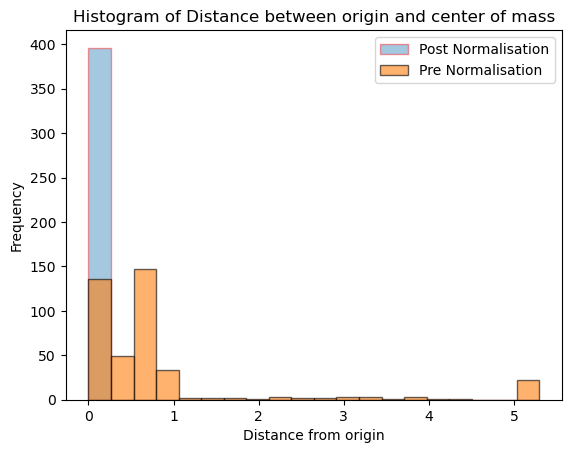

Mean of Distances (Original, Normalized): 40.236956179797765 - 1.2907188246851814e-10
Median Distances (Original, Normalized): 0.5724530438793703 - 1.1291304655826957e-10
Sum of Distances (Original, Normalized): 16658.099858436275 - 5.111246545753318e-08
SD of Distances (Original, Normalized): 784.728813206298 - 1.1518496388469961e-10
Max of Distances (Original, Normalized): 15987.017078567413 - 1.7730533835401165e-09 - ../shapes/Violin/D00598.obj - ../normshapes/RectangleTable/m917.obj


In [6]:

origDist = euclidean_distances(origDF["CenterOfMass"])
normDist = euclidean_distances(normDF["CenterOfMass"])

quantile = np.quantile(origDist,0.95)
print(quantile)
#Get Outliers
maxindOrig = np.argmax(origDist)
maxindNorm = np.argmax(normDist)

plt.hist(np.clip(normDist, 0, quantile), bins=20, edgecolor='red',alpha=0.4,label='Post Normalisation',range=[0, quantile])
plt.hist(np.clip(origDist, 0, quantile), bins=20, edgecolor='black',alpha=0.6,label='Pre Normalisation', range=[0, quantile])
plt.legend()

# Adding labels and title
plt.xlabel('Distance from origin')
plt.ylabel('Frequency')
plt.title('Histogram of Distance between origin and center of mass')

# Display the histogram
plt.show()


print(f"Mean of Distances (Original, Normalized): {np.mean(origDist)} - {np.mean(normDist)}")
print(f"Median Distances (Original, Normalized): {np.median(origDist)} - {np.median(normDist)}")

print(f"Sum of Distances (Original, Normalized): {np.sum(origDist)} - {np.sum(normDist)}")
print(f"SD of Distances (Original, Normalized): {np.std(origDist)} - {np.std(normDist)}")
print(f"Max of Distances (Original, Normalized): {np.max(origDist)} - {np.max(normDist)} - {origDF.iloc[maxindOrig]['Path']} - {normDF.iloc[maxindNorm]['New Path']}")


<h2>Angle Sum </h2>
<p>Two paralell vectors will have a cross-product of 1. If all three eigenvectors are paralell with the unit axis, this custom measure is 0. The highest possible value is 3, (all eigenvectors are orthogonal to the unit-axis) This is the case for objects that are aligned along the "wrong" axis, values between 0 and 3 indicate that the objects are not aligned along one or more axis.</p>

In [7]:
def getAngleSum(eigenvalues,eigenvectors):
    if(pd.isna(eigenvalues) or pd.isna(eigenvectors)):
        return np.inf
    #np.array([list(map(float, x.replace('[', '').replace(']', '').split())) for x in list1])
    eigenvectors =[list(map(float,x)) 
                   for x in map(lambda x: x.split(),
                                filter(None,
                                       [x.replace('[', '').replace(']', '').strip() 
                                        for x in eigenvectors.split("]")]))]
    
    eigenvalues = list(map(float,eigenvalues.replace('[', '').replace(']', '').split()))
    
    #print(eigenvalues,eigenvectors)
    ranking = np.argpartition(eigenvalues, 2)
    x_align = np.abs(np.dot(eigenvectors[ranking[2]],[1,0,0]))
    y_align = np.abs(np.dot(eigenvectors[ranking[1]],[0,1,0]))
    z_align =np.abs(np.dot(eigenvectors[ranking[0]],[0,0,1]))
    #print("Values:",x_align,y_align,z_align)
    return 3-x_align-y_align-z_align

def getAngleSums(df):
    res = []
    for i in range(0,len(df)):
        v = getAngleSum(df["Eigenvalue"][i],df["Eigenvectors"][i])
        res.append(v)
    return res



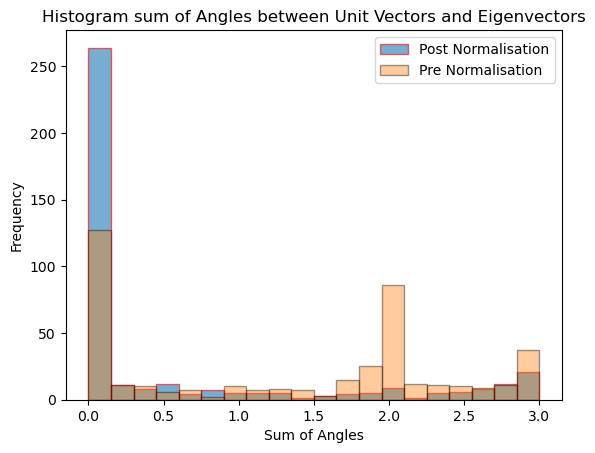

Mean of Distances (Original, Normalized): 1.3167841775893516 - 0.5667432365701667
Median Distances (Original, Normalized): 1.7312199625 - 0.0047667944999997824
Sum of Distances (Original, Normalized): 545.1486495219916 - 224.43032168178598
SD of Distances (Original, Normalized): 1.0611214986206978 - 0.974475635961534
Max of Distances (Original, Normalized): 2.9999997408701966 - 2.9997230419224 - ../shapes/Cup/m500.obj, ../normshapes/Sword/m697.obj
Max of Distances (Original, Normalized): 2.9999997408701966 - 2.9997230419224 - ../shapes/Cup/m500.obj, ../normshapes/Sword/m697.obj


In [8]:
origDist = getAngleSums(origDF)
normDist = getAngleSums(normDF)

#Get Outliers
maxindOrig = np.argmax(origDist)
minindOrig = np.argmin(origDist)
maxindNorm = np.argmax(normDist)
minindNorm = np.argmin(normDist)

plt.hist(np.clip(normDist, 0, 3), bins=20, edgecolor='red',alpha=0.6,label='Post Normalisation',range=[0, 3])
plt.hist(np.clip(origDist, 0, 3), bins=20, edgecolor='black',alpha=0.4,label='Pre Normalisation', range=[0, 3])
plt.legend()

# Adding labels and title
plt.xlabel('Sum of Angles')
plt.ylabel('Frequency')
plt.title('Histogram sum of Angles between Unit Vectors and Eigenvectors')

# Display the histogram
plt.show()


print(f"Mean of Distances (Original, Normalized): {np.mean(origDist)} - {np.mean(normDist)}")
print(f"Median Distances (Original, Normalized): {np.median(origDist)} - {np.median(normDist)}")

print(f"Sum of Distances (Original, Normalized): {np.sum(origDist)} - {np.sum(normDist)}")
print(f"SD of Distances (Original, Normalized): {np.std(origDist)} - {np.std(normDist)}")
print(f"Max of Distances (Original, Normalized): {np.max(origDist)} - {np.max(normDist)} - {origDF.iloc[maxindOrig]['Path']}, {normDF.iloc[maxindNorm]['New Path']}")
print(f"Max of Distances (Original, Normalized): {np.max(origDist)} - {np.max(normDist)} - {origDF.iloc[maxindOrig]['Path']}, {normDF.iloc[maxindNorm]['New Path']}")

<h2>Object Size</h2>

In [9]:
def get_sizes(sizel):
    res = []
    for item in sizel["Bounds"]:
        #print(item)
        res.append(get_size(item))
    return res
def get_size(bbox_str):
    bbox_str =bbox_str.replace("[","").replace("]","").strip().split()
    bbox_l = list(map(float,bbox_str))
    
    Dx = np.abs(bbox_l[0] - bbox_l[1])  
    Dy = np.abs(bbox_l[2] - bbox_l[3])  
    Dz = np.abs(bbox_l[4] - bbox_l[5])  
    
    Dmax = max(Dx, Dy, Dz) #   # largest dimension of bounding box
    
    return Dmax

print(Mesh(origDF.iloc[0]["Path"].replace("\\", "/")))
origDist = get_sizes(origDF)


vedo.mesh.Mesh at (0x1b86ac18520)                                          
name          : Mesh
file name     : ../shapes/AircraftBuoyant/m1341.obj
elements      : vertices=425 polygons=824 lines=0
position      : (0, 0, 0)
scaling       : (1.00000, 1.00000, 1.00000)
size          : average=0.279199, diagonal=1.07422
center of mass: (0.202356, 0.394062, 0.202288)
bounds        : x=(0.0250, 0.380), y=(0.0250, 0.975), z=(0.0250, 0.380)
pointdata     : "Normals" (float32), dim=3
celldata      : "GroupIds" (float32), dim=1, range=(0, 0)


10.420611499999975


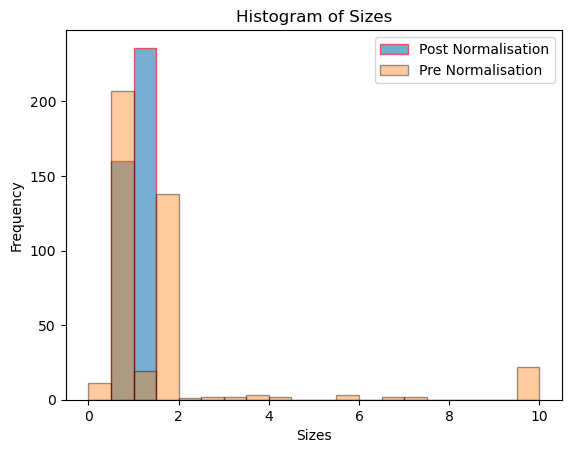

Mean of Sizes (Original, Normalized): 130.65471438963263 - 0.9999999983195454
Median Sizes (Original, Normalized): 0.95 - 1.0
SD of Sizes (Original, Normalized): 2584.9370656276565 - 4.702544810621799e-08
Max of Sizes (Original, Normalized): 52661.5975398 - 1.00000012 - ../shapes/Violin/D00598.obj, ../normshapes/Chess/m1593.obj
Min of Sizes (Original, Normalized): 0.18067299999999997 - 0.99999988 - ../shapes/TruckNonContainer/D00283.obj, ../normshapes/BuildingNonResidential/m383.obj


In [12]:
origDist = get_sizes(origDF)
normDist = get_sizes(normDF)
print(np.quantile(origDist,0.95))
#Get Outliers
maxindOrig = np.argmax(origDist)
minindOrig = np.argmin(origDist)
maxindNorm = np.argmax(normDist)
minindNorm = np.argmin(normDist)

plt.hist(np.clip(normDist, 0, 10), bins=20, edgecolor='red',alpha=0.6,label='Post Normalisation',range=[0, 10])
plt.hist(np.clip(origDist, 0, 10), bins=20, edgecolor='black',alpha=0.4,label='Pre Normalisation', range=[0, 10])
plt.legend()

# Adding labels and title
plt.xlabel('Sizes')
plt.ylabel('Frequency')
plt.title('Histogram of Sizes')

# Display the histogram
plt.show()


print(f"Mean of Sizes (Original, Normalized): {np.mean(origDist)} - {np.mean(normDist)}")
print(f"Median Sizes (Original, Normalized): {np.median(origDist)} - {np.median(normDist)}")

print(f"SD of Sizes (Original, Normalized): {np.std(origDist)} - {np.std(normDist)}")
print(f"Max of Sizes (Original, Normalized): {np.max(origDist)} - {np.max(normDist)} - {origDF.iloc[maxindOrig]['Path']}, {normDF.iloc[maxindNorm]['New Path']}")
print(f"Min of Sizes (Original, Normalized): {np.min(origDist)} - {np.min(normDist)} - {origDF.iloc[minindOrig]['Path']}, {normDF.iloc[minindNorm]['New Path']}")

<h2>Vertex Normalisation</h2>
1) Check Vertex Count <br>
2) Check Vertex Distribution

21108.79999999993


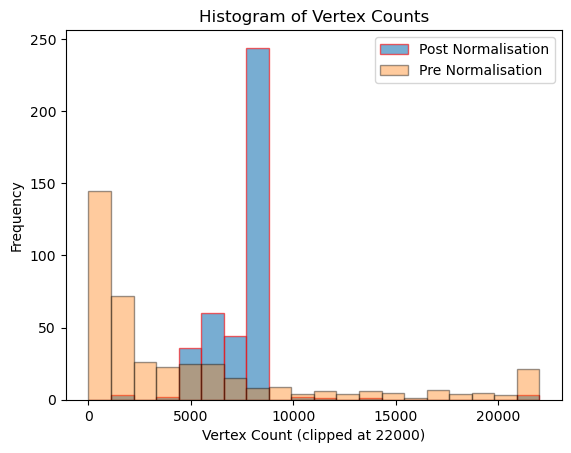

Mean # of vertices (Original, Normalized): 5556.492753623188 - 7701.909090909091
Median # of vertices (Original, Normalized): 1932.5 - 7998.0
SD of #of vertices (Original, Normalized): 8863.686058828142 - 5185.3296274461545
Max of # of vertices (Original, Normalized): 73697 - 81403 - ../shapes/Skyscraper/D00058.obj, ../normshapes/Shelf/D00781.obj
Min of # of vertices (Original, Normalized): 18 - 1341 - ../shapes/Door/D01194.obj, ../normshapes/Spoon/D00157.obj


In [14]:
origDist = origDF["Vertices"]
normDist = normDF["Vertices"]
print(np.quantile(origDist,0.95))
#Get Outliers
maxindOrig = np.argmax(origDist)
minindOrig = np.argmin(origDist)
maxindNorm = np.argmax(normDist)
minindNorm = np.argmin(normDist)

plt.hist(np.clip(normDist, 0, 22000), bins=20, edgecolor='red',alpha=0.6,label='Post Normalisation',range=[0,22000])
plt.hist(np.clip(origDist, 0, 22000), bins=20, edgecolor='black',alpha=0.4,label='Pre Normalisation',range=[0,22000])
plt.legend()

# Adding labels and title
plt.xlabel('Vertex Count (clipped at 22000)')
plt.ylabel('Frequency')
plt.title('Histogram of Vertex Counts')

# Display the histogram
plt.show()


print(f"Mean # of vertices (Original, Normalized): {np.mean(origDist)} - {np.mean(normDist)}")
print(f"Median # of vertices (Original, Normalized): {np.median(origDist)} - {np.median(normDist)}")

print(f"SD of #of vertices (Original, Normalized): {np.std(origDist)} - {np.std(normDist)}")
print(f"Max of # of vertices (Original, Normalized): {np.max(origDist)} - {np.max(normDist)} - {origDF.iloc[maxindOrig]['Path']}, {normDF.iloc[maxindNorm]['New Path']}")
print(f"Min of # of vertices (Original, Normalized): {np.min(origDist)} - {np.min(normDist)} - {origDF.iloc[minindOrig]['Path']}, {normDF.iloc[minindNorm]['New Path']}")

In [ ]:
origDist = origDF["Vertices"]
normDist = normDF["Vertices"]
print(np.quantile(origDist,0.95))
#Get Outliers
maxindOrig = np.argmax(origDist)
minindOrig = np.argmin(origDist)
maxindNorm = np.argmax(normDist)
minindNorm = np.argmin(normDist)

plt.hist(np.clip(normDist, 0, 22000), bins=20, edgecolor='red',alpha=0.6,label='Post Normalisation',range=[0,22000])
plt.hist(np.clip(origDist, 0, 22000), bins=20, edgecolor='black',alpha=0.4,label='Pre Normalisation',range=[0,22000])
plt.legend()

# Adding labels and title
plt.xlabel('Vertex Count (clipped at 22000)')
plt.ylabel('Frequency')
plt.title('Histogram of Vertex Counts')

# Display the histogram
plt.show()


print(f"Mean # of vertices (Original, Normalized): {np.mean(origDist)} - {np.mean(normDist)}")
print(f"Median # of vertices (Original, Normalized): {np.median(origDist)} - {np.median(normDist)}")

print(f"SD of #of vertices (Original, Normalized): {np.std(origDist)} - {np.std(normDist)}")
print(f"Max of # of vertices (Original, Normalized): {np.max(origDist)} - {np.max(normDist)} - {origDF.iloc[maxindOrig]['Path']}, {normDF.iloc[maxindNorm]['New Path']}")
print(f"Min of # of vertices (Original, Normalized): {np.min(origDist)} - {np.min(normDist)} - {origDF.iloc[minindOrig]['Path']}, {normDF.iloc[minindNorm]['New Path']}")

45533.0


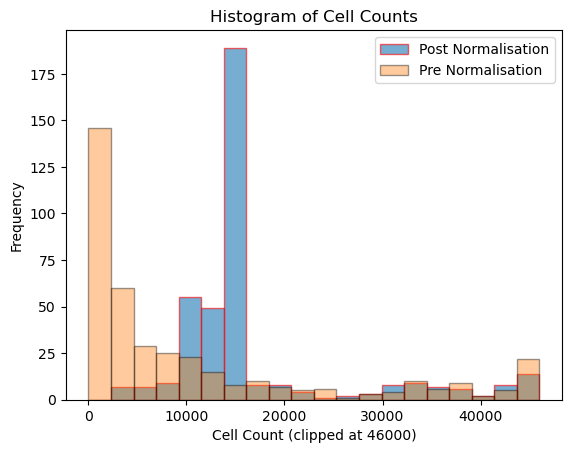

Mean # of cells (Original, Normalized): 11530.126262626263 - 18036.14898989899
Median # of cells (Original, Normalized): 4182.0 - 15536.0
SD of #of cells (Original, Normalized): 16419.70526621938 - 13365.809780420634
Max of # of cells (Original, Normalized): 119540 - 159202 - ../shapes/Car/m1556.obj, ../normshapes/Shelf/D00781.obj
Min of # of cells (Original, Normalized): 18 - 2579 - ../shapes/Door/D01194.obj, ../normshapes/Apartment/D00496.obj


In [21]:
origDist = origDF["Cells"]
normDist = normDF["Cells"]
print(np.quantile(origDist,0.95))
#Get Outliers
maxindOrig = np.argmax(origDist)
minindOrig = np.argmin(origDist)
maxindNorm = np.argmax(normDist)
minindNorm = np.argmin(normDist)

plt.hist(np.clip(normDist, 0, 46000), bins=20, edgecolor='red',alpha=0.6,label='Post Normalisation',range=[0,46000])
plt.hist(np.clip(origDist, 0, 46000), bins=20, edgecolor='black',alpha=0.4,label='Pre Normalisation',range=[0,46000])
plt.legend()

# Adding labels and title
plt.xlabel('Cell Count (clipped at 46000)')
plt.ylabel('Frequency')
plt.title('Histogram of Cell Counts')

# Display the histogram
plt.show()


print(f"Mean # of cells (Original, Normalized): {np.mean(origDist)} - {np.mean(normDist)}")
print(f"Median # of cells (Original, Normalized): {np.median(origDist)} - {np.median(normDist)}")

print(f"SD of #of cells (Original, Normalized): {np.std(origDist)} - {np.std(normDist)}")
print(f"Max of # of cells (Original, Normalized): {np.max(origDist)} - {np.max(normDist)} - {origDF.iloc[maxindOrig]['Path']}, {normDF.iloc[maxindNorm]['New Path']}")
print(f"Min of # of cells (Original, Normalized): {np.min(origDist)} - {np.min(normDist)} - {origDF.iloc[minindOrig]['Path']}, {normDF.iloc[minindNorm]['New Path']}")

In [22]:
origDist = origDF["Distribution"]
normDist = normDF["Distribution"]
print(np.quantile(origDist,0.95))
#Get Outliers
maxindOrig = np.argmax(origDist)
minindOrig = np.argmin(origDist)
maxindNorm = np.argmax(normDist)
minindNorm = np.argmin(normDist)

plt.hist(np.clip(normDist, 0, 46000), bins=20, edgecolor='red',alpha=0.6,label='Post Normalisation',range=[0,46000])
plt.hist(np.clip(origDist, 0, 46000), bins=20, edgecolor='black',alpha=0.4,label='Pre Normalisation',range=[0,46000])
plt.legend()

# Adding labels and title
plt.xlabel('Cell Count (clipped at 46000)')
plt.ylabel('Frequency')
plt.title('Histogram of Cell Counts')

# Display the histogram
plt.show()


print(f"Mean # of Distribution (Original, Normalized): {np.mean(origDist)} - {np.mean(normDist)}")
print(f"Median # of Distribution (Original, Normalized): {np.median(origDist)} - {np.median(normDist)}")

print(f"SD of #of Distribution (Original, Normalized): {np.std(origDist)} - {np.std(normDist)}")
print(f"Max of # of Distribution (Original, Normalized): {np.max(origDist)} - {np.max(normDist)} - {origDF.iloc[maxindOrig]['Path']}, {normDF.iloc[maxindNorm]['New Path']}")
print(f"Min of # of Distribution (Original, Normalized): {np.min(origDist)} - {np.min(normDist)} - {origDF.iloc[minindOrig]['Path']}, {normDF.iloc[minindNorm]['New Path']}")

KeyError: 'Distribution'